In [1]:
!pip install ipywidgets
!pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from ipywidgets import interact, fixed, interact_manual
import ipywidgets
from scipy.signal import argrelextrema
from itertools import product
from tqdm import tqdm

rcParams['figure.figsize'] = 10,7
rcParams['font.size'] = 11
color_map = ["tab:blue", "tab:cyan", "tab:red", "tab:green"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.9 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Introduction
Our goal is to implement a SIR model including a new compartment $S^F$ that represents the susceptibles in the population that have fear of the disease.
In this notebook we start from the model 1 and 3 from the paper "Towards a Characterization of Behavior-Disease Models" (Perra et. al.) in which the fear is diffused if a susceptible enters in contact with an infectious (model 1) or also if a susceptible enters in an individual in the $S^F$ compartment.
We introduce both deterministic and stochastic models, but then we will drop the stochastic simulations given that for a large population they are almost identical.
We can then go further by introducing 5 age classes and using a 5x5 matrix for the average daily contacts by age, so we can model the spread of both the disease and fear for the different age classes starting from model 3.
Some analysis of the curves and phase spaces are provided for all the models.


# Model 1 and 3

1) **Basic local model, prevalence-based spread of the fear of the disease**
Susceptible individuals will adopt behavioral changes only if they interact with infectious individuals ($S + I \rightarrow S^F + I$)

3) **Improved local model, belief-based spread of the fear of the disease**<br>
In addition to the local prevalence-based spread of the fear of the disease, in this case we assume that the fear contagion may also occur by contacting individuals who have already acquired fear/awareness of the disease ($S + S^F \rightarrow 2S^F$)

### Deterministic and stochastic models

In [2]:
def simulate_deterministic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T):

    ### function that simulate SIR with fear deterministically

    dt = 0.1
    q = int(T/dt)
    time = np.arange(q)*dt
    
    S = np.zeros(q)
    S_F = np.zeros(q)
    I = np.zeros(q)
    R = np.zeros(q)
    
    S[0] = N - R0 - S_F0 - I0
    S_F[0] = S_F0
    I[0] = I0
    R[0] = R0
    
    for t in range(q-1):
        
        if model==1:
            S[t+1] = S[t] + (1/N)*(- beta*S[t]*I[t] - beta_F*S[t]*I[t] + mu_F*S_F[t]*(S[t]+R[t]))*dt
            S_F[t+1] = S_F[t] + (1/N)*(- r_b*beta*S_F[t]*I[t] + beta_F*S[t]*I[t] - mu_F*S_F[t]*(S[t]+R[t]))*dt
        elif model==3:
            S[t+1] = S[t] + (1/N)*(-beta*S[t]*I[t] - beta_F*S[t]*(I[t]+alpha*S_F[t]) + mu_F*S_F[t]*(S[t]+R[t]))*dt
            S_F[t+1] = S_F[t] + (1/N)*(-r_b*beta*S_F[t]*I[t] + beta_F*S[t]*(I[t]+alpha*S_F[t]) - mu_F*S_F[t]*(S[t]+R[t]))*dt 

        I[t+1] = I[t] + (- mu*I[t] + (1/N)*(beta*S[t]*I[t] + r_b*beta*S_F[t]*I[t]))*dt
        R[t+1] = R[t] + (mu*I[t])*dt 
    
    return time, S, S_F, I, R

In [3]:
def simulate_stochastic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T):

    ### function that simulate SIR with fear stochastically

    dt = 1
    q = int(T/dt)
    time = np.arange(q)*dt
    
    S = np.zeros(q)
    S_F = np.zeros(q)
    I = np.zeros(q)
    R = np.zeros(q)
    
    S[0] = N - R0 - S_F0 - I0
    S_F[0] = S_F0
    I[0] = I0
    R[0] = R0
    
    for t in range(q-1):
        
        FOI = beta*I[t]/N 
        FOI_F = r_b*beta*I[t]/N
        if model==1:
            rate_scare = beta_F*I[t]/N    
        elif model==3:
            rate_scare = beta_F*I[t]/N + beta_F*alpha*S_F[t]/N
        rate_relief = mu_F*(S[t]+R[t])/N
        
        infected = np.random.binomial(S[t], FOI)
        infected_F = np.random.binomial(S_F[t], FOI_F)
        scared = np.random.binomial(S[t], rate_scare)
        relieved = np.random.binomial(S_F[t], rate_relief)
        recovered = np.random.binomial(I[t], mu)
        
        S[t+1] = S[t] - infected - scared + relieved
        S_F[t+1] = S_F[t] - infected_F + scared - relieved
        I[t+1] = I[t] - recovered + infected + infected_F
        R[t+1] = R[t] + recovered
    
    return time, S, S_F, I, R

Parameters of the epidemic that will be simulated

In [4]:
# model parameters

model = 3

if model==1:
    R_0 = 2
    R_F = 2.5
    r_b = 0.5
    mu = 0.1
    mu_F = 0.1
    alpha = 0
    beta = mu*R_0
    beta_F = mu_F*R_F
elif model==3:
    R_0 = 2.3 #2 #params to have 2 peaks
    R_F = 2 #10
    r_b = 0.4 #0.1
    mu = 0.4 #0.1
    mu_F = 0.5 #0.1
    alpha = 0.4 #0.1
    beta = mu*R_0
    beta_F = mu_F*R_F/alpha

R0 = 0  # initially recovered
S_F0 = 0  # initially feared
I0 = 1  # initially infected
N = 60*10**6 # population
T = 500 # simulation time

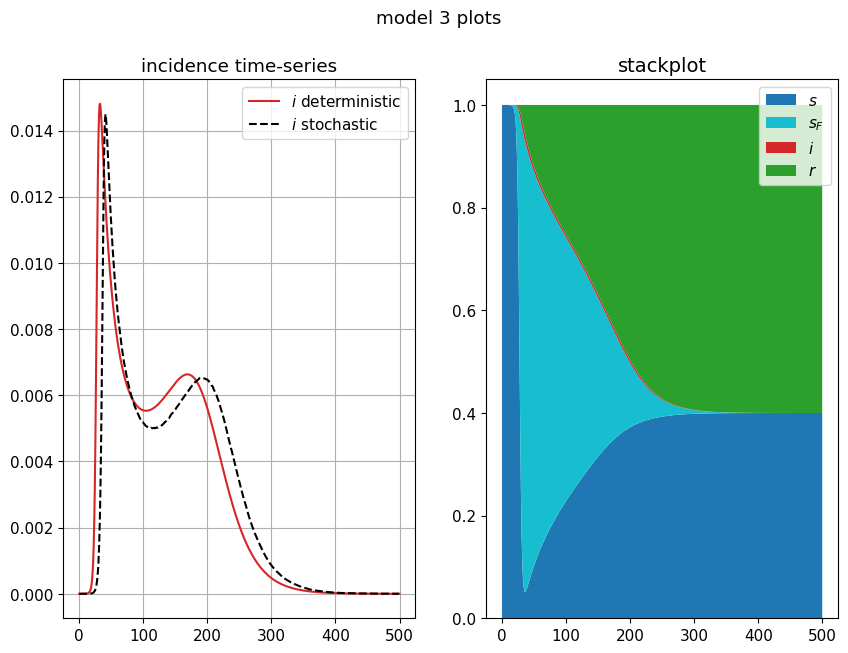

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('model ' + str(model) + ' plots')

time, S, S_F, I, R = simulate_deterministic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
ax1.plot(time, I/N, label="$i$ deterministic", c='tab:red')
ax2.stackplot(time, S/N, S_F/N, I/N, R/N, labels=['$s$', '$s_F$', '$i$', '$r$'], colors=color_map)
ax2.set_title('stackplot', fontsize=14)
ax2.legend()

time, S, S_F, I, R = simulate_stochastic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
ax1.plot(time, I/N, label="$i$ stochastic", c='black', ls='--')
ax1.set_title('incidence time-series')
ax1.legend()
ax1.grid()

plt.show()

### Interactive plots

In [6]:
def simulate_plot(plot, model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T):

    time, S, S_F, I, R = simulate_deterministic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)

    if plot=='time-series':
        plt.plot(time, I/N, label="$i$", c='tab:red')
        plt.plot(time, S_F/N, label="$s_f$", c='tab:cyan')
        plt.plot(time, S/N, label="$s$", c='tab:blue')
        plt.plot(time, R/N, label="$r$", c='tab:green')
        plt.title('model '+str(model), fontsize=14)
        plt.legend()
        plt.grid()
    elif plot=='stackplot':
        plt.stackplot(time, S/N, S_F/N, I/N, R/N, labels=['$s$', '$s_F$', '$i$', '$r$'], colors=color_map)
        plt.title('model '+str(model), fontsize=14)
        plt.legend()
        

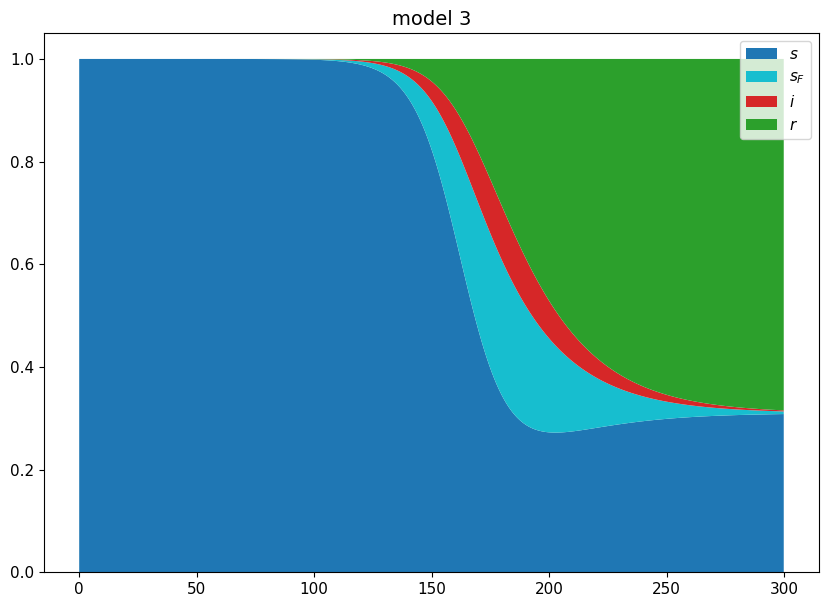

interactive(children=(FloatSlider(value=0.2, description='$\\beta$', max=0.5, min=0.02, step=0.01), FloatSlide…

In [7]:
#choose the interactive plot type
plot='stackplot'

interact(simulate_plot,
        plot = fixed(plot),
        model = fixed(model),
        beta = ipywidgets.FloatSlider(min=0.02, max=0.5, step=0.01, value=0.2, description=r"$\beta$"),
        beta_F = ipywidgets.FloatSlider(min=0.02, max=2, step=0.01, value=0.25, description=r"$\beta_F$"), 
        r_b = ipywidgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description=r"$r_{\beta}$"),
        mu = ipywidgets.FloatSlider(min=0, max=0.15, step=0.01, value=0.1, description=r"$\mu$"),
        mu_F = ipywidgets.FloatSlider(min=0, max=0.15, step=0.01, value=0.1, description=r"$\mu_F$"),
        alpha = ipywidgets.FloatSlider(min=0, max=1, step=0.01, value=alpha, description=r"$\alpha$"),
        R0 = fixed(R0),
        S_F0 = fixed(S_F0),
        I0 = fixed(I0),
        N = fixed(N),
        T = ipywidgets.FloatSlider(min=100, max=1000, step=100, value=300, description=r"$T$"),
        )

plt.show()

## Phase diagrams



### Infection waves on $R_{0}$-$\beta_{F}$ plane

In [8]:
def n_peaks(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T):
    R_0 = beta/mu
    time, S, S_F, I, R = simulate_deterministic(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
    number_of_peaks = len(argrelextrema(I, np.greater)[0])
    
    return R_0, beta_F, number_of_peaks, r_b, R[-1]

In [9]:
R0 = 0  # initially recovered
S_F0 = 0  # initially feared
I0 = 1  # initially infected
N = 60*10**6 # population
T = 500 # simulation time

Create dataframes with the data from model 1 and 3 to be used for the plots


In [10]:
model = 1

R_0_ = np.linspace(1.1, 6, 100)
mu = 0.1
beta_ = R_0_*mu

r_b_ = [0,0.15,0.3]

mu_F = 0.1
alpha = 1
beta_F_ = np.linspace(0, 10, 100)

cmb = list(product(beta_, beta_F_)) #all combinations of R_0 and beta_F

data1 = []
for r_b in tqdm(r_b_):
    for beta, beta_F in cmb:
        row = n_peaks(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
        data1.append(row)
        
df1 = pd.DataFrame(data1, columns=['R_0', 'beta_F', 'number of peaks', 'r_b', 'R_inf'])

100%|██████████| 3/3 [14:18<00:00, 286.31s/it]


In [11]:
model = 3

R_0_ = np.linspace(1.1, 6, 100)
mu = 0.4
beta_ = R_0_*mu

r_b_ = [0,0.15,0.3]

mu_F = 0.5
alpha = 0.05
beta_F_ = np.linspace(0, 30, 100)

cmb = list(product(beta_, beta_F_))

data3 = []
for r_b in tqdm(r_b_):
    for beta, beta_F in cmb:
        row = n_peaks(model, beta, beta_F, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
        data3.append(row)
        
df3 = pd.DataFrame(data3, columns=['R_0', 'beta_F', 'number of peaks', 'r_b', 'R_inf'])

100%|██████████| 3/3 [14:43<00:00, 294.43s/it]


In [12]:
def n_peaks_plot(model, df, r_b):
    
    df1 = df[df['r_b']==r_b]
    
    if model==1:
        if r_b==0:
            n = 4
        if r_b==0.15:
            n = 3
        if r_b==0.3:
            n = 2

    if model==3:
        n = 3 #always 3 peaks

    cmap = plt.get_cmap('viridis', n)

    plt.scatter(x=df1['R_0'], y=df1['beta_F'], c=df1['number of peaks'], s=30, marker ="s", cmap=cmap)
    plt.xlabel('$R_0$', size=12)
    plt.ylabel(r'$\beta_F$', size=12)

    ax = plt.gca()

    if model == 1:
        ax.set_ylim([0, 10])
        ax.set_xlim([1.25, 6])
    elif model == 3:
        ax.set_ylim([0, 30])
        ax.set_xlim([1.1, 6])

    cbar=plt.colorbar(ticks=range(n+1))
    cbar.ax.tick_params(axis='y', direction='inout')
    cbar.ax.set_ylabel('Number of disease activity peaks', size=12)

    plt.title(r"$r_{\beta} = %1.2f$" % r_b)

    plt.show()

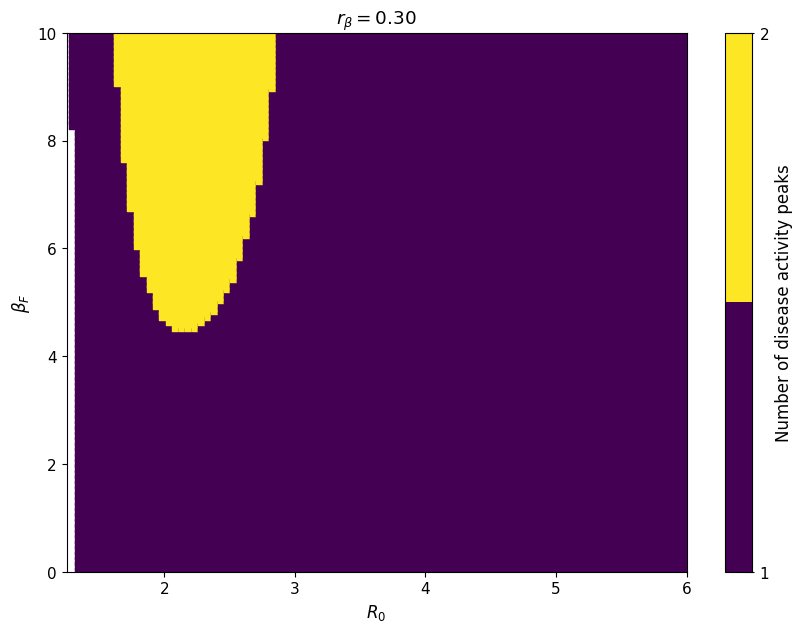

In [13]:
n_peaks_plot(1, df1[df1['number of peaks']>0], 0.3)

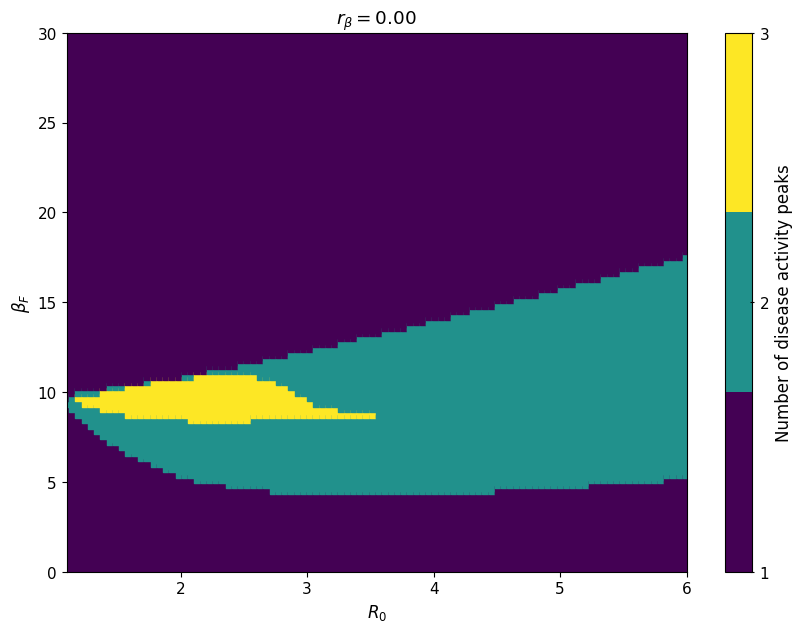

In [14]:
n_peaks_plot(3, df3, 0)

### Total infections in $R_{0}$-$R_{F}$ plane

In [15]:
# model parameters
model = 3

mu = 0.4
mu_F = 0.5
alpha = 0.05
r_b = 0.4

R0 = 0  # initially recovered
S_F0 = 0  # initially feared
I0 = 1  # initially infected
N = 60*10**6 # population
T = 1000 # simulation time

R_0_ = np.linspace(0, 4, 100)
beta_ = R_0_*mu
R_F_ = np.linspace(0, 3, 100)
beta_F_ = mu_F*R_F_/alpha

X, Y = np.meshgrid(R_F_, R_0_)

In [16]:
z = np.zeros((100,100))
for i, beta_f in enumerate(tqdm(beta_F_)):
    for j, beta in enumerate(beta_):
        row = n_peaks(model, beta, beta_f, r_b, mu, mu_F, alpha, R0, S_F0, I0, N, T)
        z[j,i] = row[4]/N  # one has to invert the axes for some reason

100%|██████████| 100/100 [09:45<00:00,  5.85s/it]


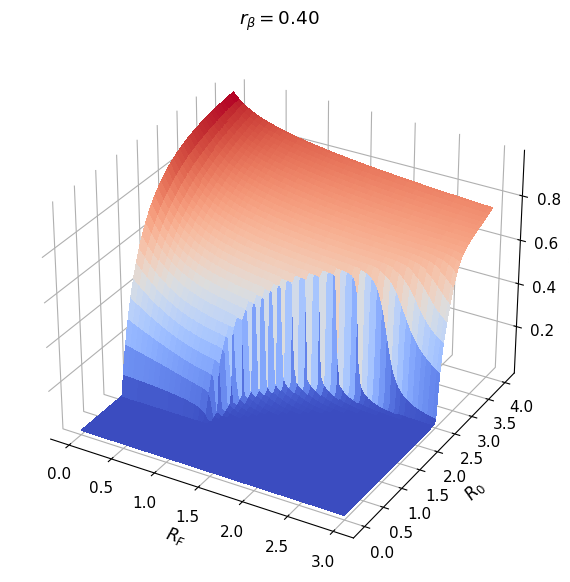

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='coolwarm', linewidth=0, antialiased=False)
ax.set_title(r"$r_{\beta} = %1.2f$" % r_b)
ax.set_xlabel('$R_F$', size=12)
ax.set_ylabel('$R_0$', size=12)
ax.set_zlabel(r'$r_{\infty}$', size=12)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

Text(0, 0.5, '$R_0$')

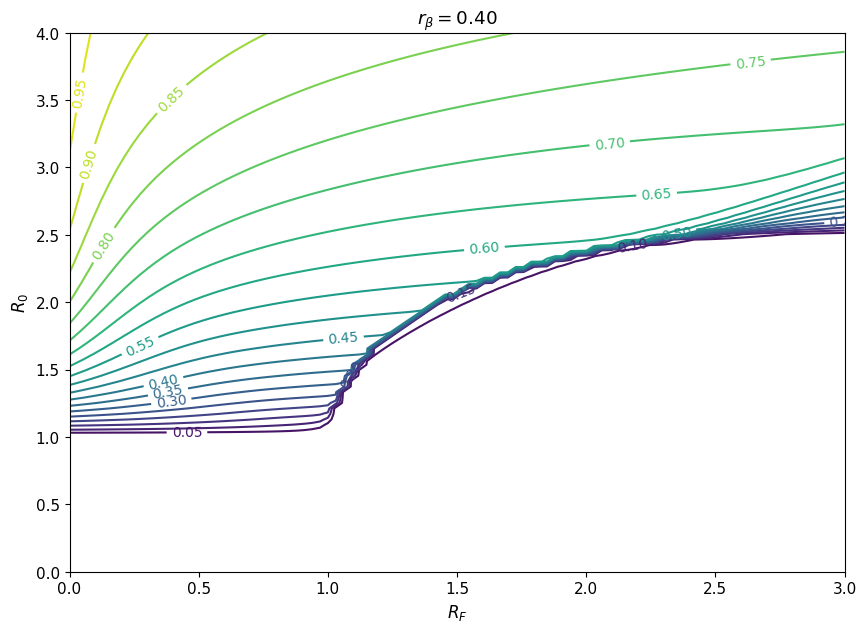

In [18]:
fig, ax = plt.subplots()
cs = ax.contour(X, Y, z, levels=20)
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title(r"$r_{\beta} = %1.2f$" % r_b)
ax.set_xlabel('$R_F$', size=12)
ax.set_ylabel('$R_0$', size=12)

# Model 3 with contacts by age

Let's consider $M$ age classes, each with population $N_i$ ($i = 1,...,M$), such that $\sum_i N_i = N$.
The equations of the model are the following:

$$
\begin{aligned}
 \frac{dS_i}{dt} = -\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} - \beta_F S_i \sum_{j} k_{ij}\frac{(I_j + \alpha S_j^F)}{N_j} + \mu_F S_i^F \sum_{j} k_{ij}\frac{(S_j + R_j)}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dS_i^F}{dt} = - r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j} + \beta_F S_i \sum_{j} k_{ij}\frac{(I_j + \alpha S_j^F)}{N_j} - \mu_F S_i^F \sum_{j} k_{ij}\frac{(S_j + R_j)}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dI_i}{dt} = - \mu I_i +\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} + r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dR_i}{dt} = \mu I_i 
\end{aligned}
$$

The additional ingridient is the contact matrix $k_{ij}$, taken from http://www.socialcontactdata.org/socrates/ selecting "Italy (Mossong 2008)" and imposing the following age classes: $[0,10), [10,25), [25,50), [50,65), 65+ $

In [19]:
def deterministic_simulation(R_0, R_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N, T, k):
      
    dt = 0.1
    q = int(T/dt)
    time = np.arange(q)*dt
    beta = mu*R_0
    beta_F = mu_F*R_F/alpha
    #R_0 = beta/mu
    #R_F = beta_F*alpha/mu_F
    N_tot = sum(N)

    nc = len(k)
    
    S = np.zeros((nc, q))
    S_F = np.zeros((nc, q))
    I = np.zeros((nc, q))
    R = np.zeros((nc, q))

    for i in range(nc):
        S[i,0] = N[i] - R0[i] - S_F0[i] - I0[i]
        S_F[i,0] = S_F0[i]
        I[i,0] = I0[i]
        R[i,0] = R0[i]
        
    for t in range(q-1):
        for i in range(nc):

            S_to_I = beta*S[i,t]*np.dot(k[i], I[:,t]/N)
            S_to_SF = gamma[i]*beta_F*S[i,t]*np.dot(k[i], (I[:,t] + alpha*S_F[:,t])/N)
            SF_to_S = mu_F*S_F[i,t]*np.dot(k[i], (S[:,t]+R[:,t])/N)
            SF_to_I = r_b*beta*S_F[i,t]*np.dot(k[i], I[:,t]/N)
            I_to_R = mu*I[i,t]
            
            S[i,t+1] = S[i,t] + (-S_to_I - S_to_SF + SF_to_S)*dt
            S_F[i,t+1] = S_F[i,t] + (-SF_to_I + S_to_SF - SF_to_S)*dt
            I[i,t+1] = I[i,t] + (-I_to_R + S_to_I + SF_to_I)*dt
            R[i,t+1] = R[i,t] + (I_to_R)*dt

    return time, S, S_F, I, R, R[:, -1]/N

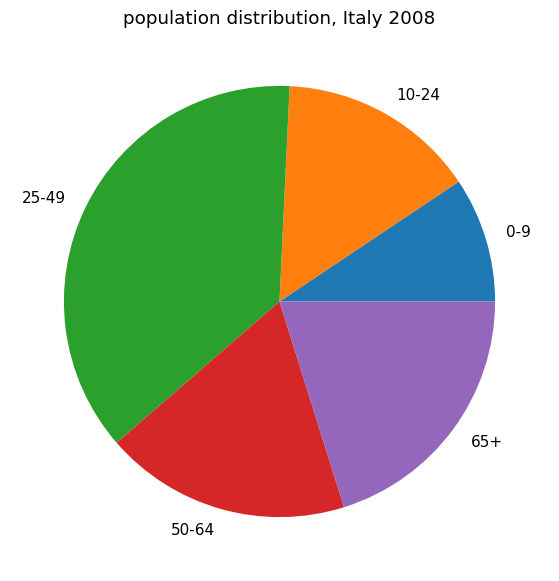

In [20]:
# model parameters

R_0 = 0.2 #0.12435 critical
mu = 0.1
R_F = 0.8 #1.0 critical
mu_F = 0.1
r_b = 0.48
alpha = 0.05
gamma = [1, 1, 1, 1, 1] # modificator of fear (to not use it, set all to one)

R0 = [0, 0, 0, 0, 0]                  # initially recovered
S_F0 = [0, 0, 0, 0, 0]                # initially feared
I0 = [0, 0, 1, 0, 0]                  # initially infected
T = 500                               # simulation time

N_tot = 60*10**6
labels = ['0-9', '10-24', '25-49', '50-64', '65+']
classes = np.array([0.094, 0.149, 0.372, 0.185, 0.202])     # population Italy 2008 - dati ISTAT
N = N_tot*classes           

plt.pie(classes, labels=labels)
plt.title('population distribution, Italy 2008')
plt.show()

/tmp/ipykernel_76/4194468731.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+lab)
/tmp/ipykernel_76/4194468731.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+lab)
[[ 7.39677519  1.65767433  5.56867511  1.95565292  1.12545173]
 [ 1.03011503 14.21852772  6.465301    3.37043051  0.88541503]
 [ 1.39898044  2.61373768  9.66429715  3.22466939  1.58484117]
 [ 0.99790082  2.76754358  6.54969437  4.20922947  2.34146693]
 [ 0.53794872  0.68104277  3.01536569  2.19334239  2.32233697]]
[19.64262741  9.35128428  5.82461466  2.37497237  0.61766779]


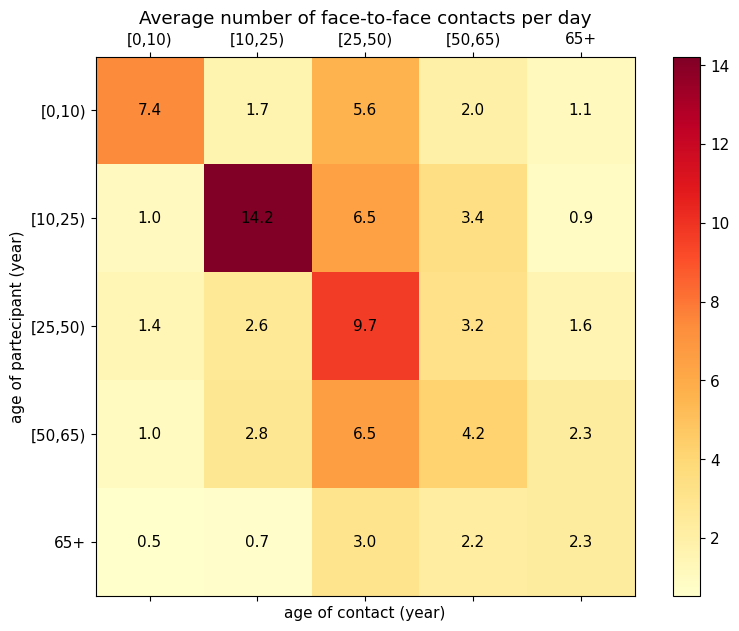

In [21]:
#italy (Mossong 2008) average contact per age [0,10,25,50,65]
k = np.loadtxt(open("social_contact_matrix.csv", "rb"), delimiter=",", skiprows=1)
lab = ['[0,10)', '[10,25)', '[25,50)', '[50,65)', '65+']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(k, cmap='YlOrRd')
fig.colorbar(cax, ticks=[2,4,6,8,10,12,14])
ax.set_title('Average number of face-to-face contacts per day')
ax.set_xlabel('age of contact (year)')
ax.set_ylabel('age of partecipant (year)')
ax.set_xticklabels(['']+lab)
ax.set_yticklabels(['']+lab)

for (i, j), z in np.ndenumerate(k):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.show()

print(k)
w, v = np.linalg.eig(k)
print(w)

In [22]:
R_0_ = np.linspace(0, 0.2, 100)
eigmax0 = np.zeros_like(R_0_)
R_F_ = np.linspace(0, 2, 100)
eigmaxF = np.zeros_like(R_F_)

for i, r0 in enumerate(R_0_):
    A = (mu*r0*N/N_tot)*k - np.identity(5)*mu
    wA, vA = np.linalg.eig(A)
    eigmax0[i] = np.max(wA)

for i, rf in enumerate(R_F_):
    B = (mu_F*rf*N/N_tot)*k - np.identity(5)*((mu_F/N_tot)*np.dot(k,N))
    wB, vB = np.linalg.eig(B)
    eigmaxF[i] = np.max(wB)

print((N/N_tot)*k)
wi, vi = np.linalg.eig((N/N_tot)*k)
print(wi) # the max eigenvalue is related to R_0 critical

[[0.69529687 0.24699348 2.07154714 0.36179579 0.22734125]
 [0.09683081 2.11856063 2.40509197 0.62352964 0.17885384]
 [0.13150416 0.38944691 3.59511854 0.59656384 0.32013792]
 [0.09380268 0.41236399 2.43648631 0.77870745 0.47297632]
 [0.05056718 0.10147537 1.12171604 0.40576834 0.46911207]]
[4.73251708 1.66710323 0.12046968 0.60722877 0.5294768 ]


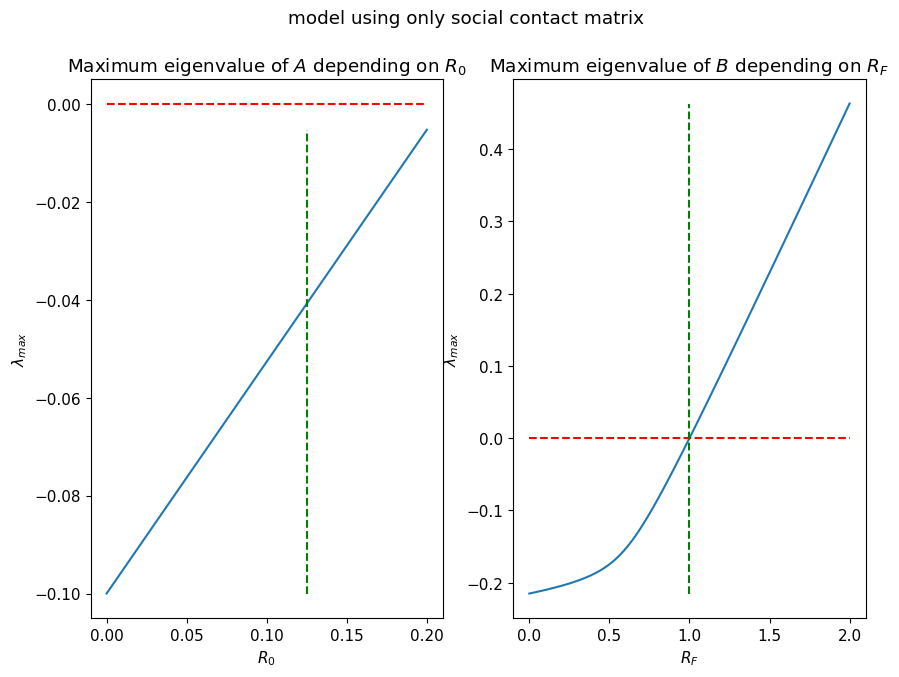

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('model using only social contact matrix')

ax1.plot(R_0_, eigmax0)
ax1.hlines(0, R_0_[0], R_0_[-1], colors = 'r', linestyles='--')
ax1.vlines(0.125, eigmax0[0], eigmax0[-1], colors = 'g', linestyles='--')
ax1.set_title(r"Maximum eigenvalue of $A$ depending on $R_0$")
ax1.set_xlabel(r"$R_0$")
ax1.set_ylabel(r"$\lambda_{max}$")

ax2.plot(R_F_, eigmaxF)
ax2.hlines(0, R_F_[0], R_F_[-1], colors = 'r', linestyles='--')
ax2.vlines(1, eigmaxF[0], eigmaxF[-1], colors = 'g', linestyles='--')
ax2.set_title(r"Maximum eigenvalue of $B$ depending on $R_F$")
ax2.set_xlabel(r"$R_F$")
ax2.set_ylabel(r"$\lambda_{max}$")

plt.show()

In [24]:
time, S, S_F, I, R, r_inf = deterministic_simulation(R_0, R_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N, T, k)

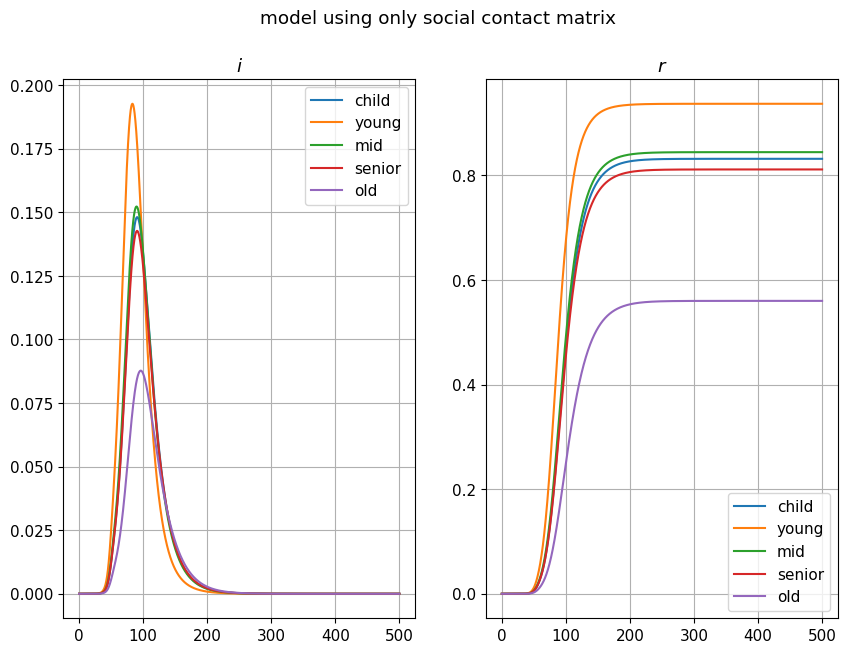

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('model using only social contact matrix')

ax1.set_title('$i$')
ax1.plot(time,I[0]/N[0], label='child')
ax1.plot(time,I[1]/N[1], label='young')
ax1.plot(time,I[2]/N[2], label='mid')
ax1.plot(time,I[3]/N[3], label='senior')
ax1.plot(time,I[4]/N[4], label='old')
ax1.legend()
ax1.grid()

ax2.set_title('$r$')
ax2.plot(time,R[0]/N[0], label='child')
ax2.plot(time,R[1]/N[1], label='young')
ax2.plot(time,R[2]/N[2], label='mid')
ax2.plot(time,R[3]/N[3], label='senior')
ax2.plot(time,R[4]/N[4], label='old')
ax2.legend()
ax2.grid()

plt.show()

## Fear analysis

In [26]:
# model parameters

R_0 = 0.15 #0.12435 critical
mu = 0.1
R_F = 0.8 #1.0 critical
mu_F = 0.1
r_b = 0.48
alpha = 0.05
gamma = [1,1,1,1,3] # modificator of fear (to not use it, set all to one)

In [27]:
def modifier(r0, rf, r_beta, max_gamma):
    
    gamma_ = np.linspace(1, max_gamma, 10)
    zr = np.zeros((10, 5))
    for i, gamm in enumerate(gamma_):
        g = [1,1,1,1,gamm]
        row = deterministic_simulation(r0, rf, r_beta, mu, mu_F, alpha, g, R0, S_F0, I0, N, T, k)
        zr[i] = row[5]

    plt.plot(gamma_, zr[:,0], label = 'child')
    plt.plot(gamma_, zr[:,1], label = 'young')
    plt.plot(gamma_, zr[:,2], label = 'min')
    plt.plot(gamma_, zr[:,3], label = 'senior')
    plt.plot(gamma_, zr[:,4], label = 'old')
    plt.xlabel(r'$\gamma$', fontsize = 15)
    plt.ylabel(r'$r_{\infty}$', fontsize = 15)
    plt.xlim(1, max_gamma)
    plt.legend()

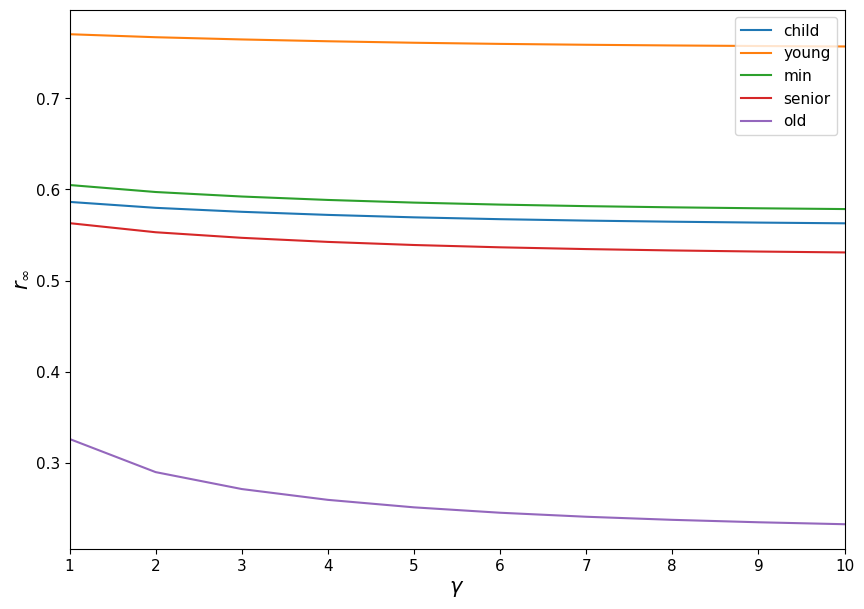

In [28]:
modifier(r0 = 0.12, rf = 0.8, r_beta = 0.48, max_gamma = 10)

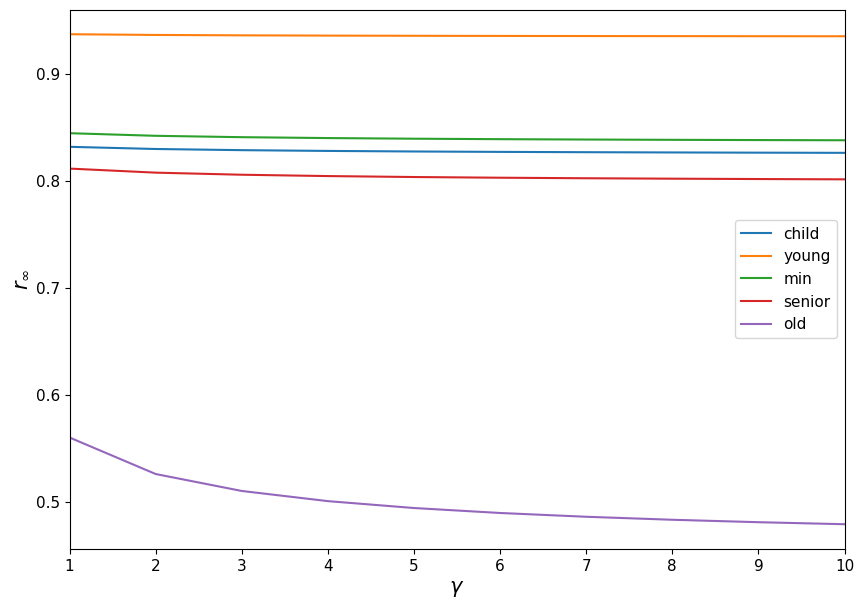

In [29]:
modifier(r0 = 0.2, rf = 0.8, r_beta = 0.48, max_gamma = 10)

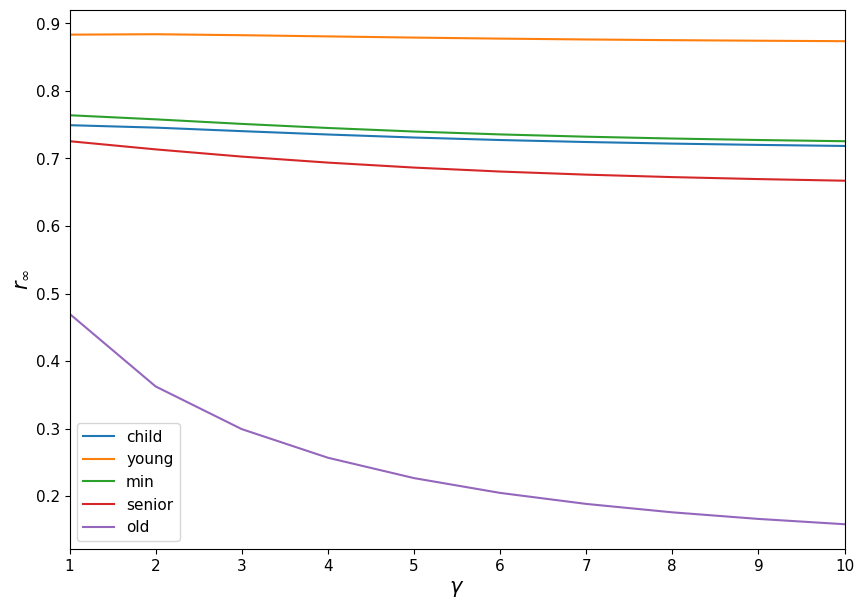

In [30]:
modifier(r0 = 0.2, rf = 0.8, r_beta = 0.1, max_gamma = 10)

### Model with increased fear for older group
Model with larger $\beta_F$ for age group 60+

$\beta_{F,60+} = \beta_F * r_{\beta_F}$
where $r_{\beta_F}$ is the factor by which we increase $\beta_F$ 

In [31]:
def deterministic_simulation_variable_beta_F(R_0, R_F, r_b, r_beta_F, mu, mu_F, alpha, R0, S_F0, I0, N, T, k):
    
    dt = 0.01
    q = int(T/dt)
    time = np.arange(q)*dt
    beta = mu*R_0
    #beta_F = mu_F*R_F/alpha

    #R_0 = beta/mu
    #R_F = beta_F*alpha/mu_F
    N_tot = sum(N)

    nc = len(k)

    beta_f = mu_F*R_F/alpha
    beta_F = np.append(np.repeat(beta_f,nc-1), beta_f*r_beta_F)

    S = np.zeros((nc, q))
    S_F = np.zeros((nc, q))
    I = np.zeros((nc, q))
    R = np.zeros((nc, q))

    for i in range(nc):
        S[i,0] = N[i] - R0[i] - S_F0[i] - I0[i]
        S_F[i,0] = S_F0[i]
        I[i,0] = I0[i]
        R[i,0] = R0[i]
        
    for t in range(q-1):
        for i in range(nc):

            S_to_I = beta*S[i,t]*np.dot(k[i], I[:,t])
            S_to_SF = beta_F[i]*S[i,t]*np.dot(k[i], (I[:,t] + alpha*S_F[:,t]))
            SF_to_S = mu_F*S_F[i,t]*np.dot(k[i], S[:,t]+R[:,t])
            SF_to_I = r_b*beta*S_F[i,t]*np.dot(k[i], I[:,t])
            I_to_R = mu*I[i,t]
         
            S[i,t+1] = S[i,t] + (1/N_tot)*(-S_to_I - S_to_SF + SF_to_S)*dt           
            S_F[i,t+1] = S_F[i,t] + (1/N_tot)*(-SF_to_I + S_to_SF - SF_to_S)*dt
            I[i,t+1] = I[i,t] + (-I_to_R + (1/N_tot)*(+ S_to_I + SF_to_I))*dt           
            R[i,t+1] = R[i,t] + (I_to_R)*dt
    

    return time, R, R[:, -1]/N

In [32]:
# model parameters

R_0 = 2 #0.12435 critical
mu = 0.1
R_F = 1.00 #1.0 critical
mu_F = 0.1
r_b = 0.48
alpha = 0.05

R0 = [0, 0, 0, 0, 0]                  # initially recovered
S_F0 = [0, 0, 0, 0, 0]                # initially feared
I0 = [0, 1, 0, 0, 0]                  # initially infected
T = 100                               # simulation time

print(k)
w, v = np.linalg.eig(k)
print(w)

[[ 7.39677519  1.65767433  5.56867511  1.95565292  1.12545173]
 [ 1.03011503 14.21852772  6.465301    3.37043051  0.88541503]
 [ 1.39898044  2.61373768  9.66429715  3.22466939  1.58484117]
 [ 0.99790082  2.76754358  6.54969437  4.20922947  2.34146693]
 [ 0.53794872  0.68104277  3.01536569  2.19334239  2.32233697]]
[19.64262741  9.35128428  5.82461466  2.37497237  0.61766779]


Text(0, 0.5, '$R_{inf,65+}$')

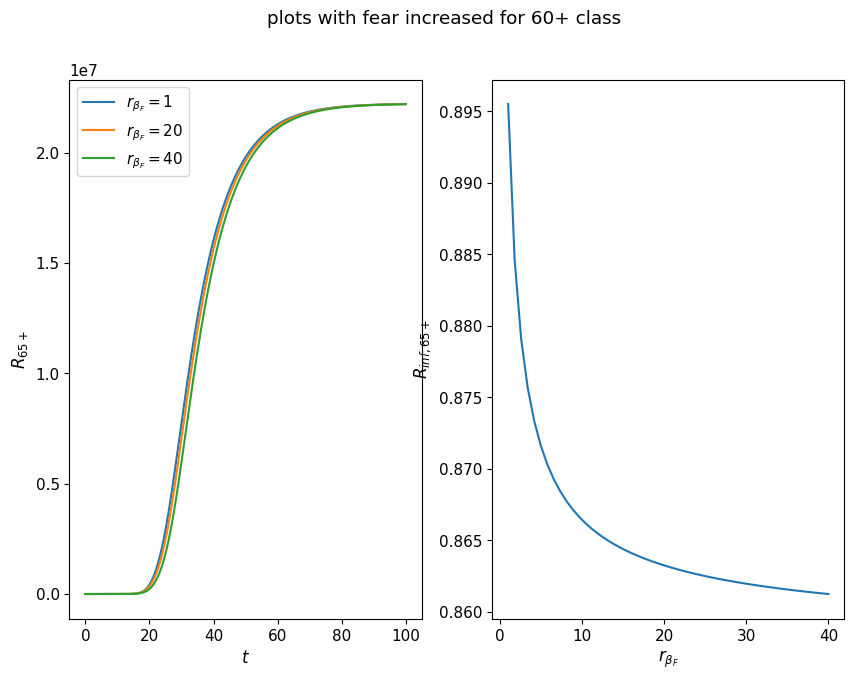

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('plots with fear increased for 60+ class')

for r_beta_F in np.linspace(1, 40, 3):
    time, R, r_inf = deterministic_simulation_variable_beta_F(R_0, R_F, r_b, r_beta_F, mu, mu_F, alpha, R0, S_F0, I0, N, T, k)
    ax1.plot(time,R[2], label=r"$r_{\beta_F} = %i$" % r_beta_F)

ax1.set_xlabel('$t$', size=12)
ax1.set_ylabel('$R_{65+}$', size=12)
ax1.legend()

r = []

for r_beta_F in np.linspace(1, 40, 50):
    time, R, r_inf = deterministic_simulation_variable_beta_F(R_0, R_F, r_b, r_beta_F, mu, mu_F, alpha, R0, S_F0, I0, N, T, k)
    r.append(r_inf[4])

ax2.plot(np.linspace(1, 40, 50),r)
ax2.set_xlabel(r'$r_{\beta_F}$', size=12)
ax2.set_ylabel('$R_{inf,65+}$', size=12)

## Phase diagram

In [34]:
# model parameters

mu = 0.1
mu_F = 0.1
r_b = 0.5
alpha = 0.05

T = 5000 

R_0_ = np.linspace(0, 0.4, 10)
R_F_ = np.linspace(0, 2, 10)

z = np.zeros((10,10,5))
for i, rf in enumerate(R_F_):
    for j, r0 in  enumerate(R_0_):
        row = deterministic_simulation(r0, rf, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N, T, k)
        z[j,i] = row[5]

/tmp/ipykernel_76/2115527188.py:28: RuntimeWarning: overflow encountered in double_scalars
  S_to_I = beta*S[i,t]*np.dot(k[i], I[:,t]/N)
/tmp/ipykernel_76/2115527188.py:29: RuntimeWarning: overflow encountered in double_scalars
  S_to_SF = gamma[i]*beta_F*S[i,t]*np.dot(k[i], (I[:,t] + alpha*S_F[:,t])/N)
/tmp/ipykernel_76/2115527188.py:30: RuntimeWarning: overflow encountered in double_scalars
  SF_to_S = mu_F*S_F[i,t]*np.dot(k[i], (S[:,t]+R[:,t])/N)
/tmp/ipykernel_76/2115527188.py:31: RuntimeWarning: overflow encountered in double_scalars
  SF_to_I = r_b*beta*S_F[i,t]*np.dot(k[i], I[:,t]/N)
/tmp/ipykernel_76/2115527188.py:34: RuntimeWarning: invalid value encountered in double_scalars
  S[i,t+1] = S[i,t] + (-S_to_I - S_to_SF + SF_to_S)*dt
/tmp/ipykernel_76/2115527188.py:35: RuntimeWarning: invalid value encountered in double_scalars
  S_F[i,t+1] = S_F[i,t] + (-SF_to_I + S_to_SF - SF_to_S)*dt
/tmp/ipykernel_76/2115527188.py:36: RuntimeWarning: invalid value encountered in double_scalars

Text(0.5, 0.5, '$R_0$')

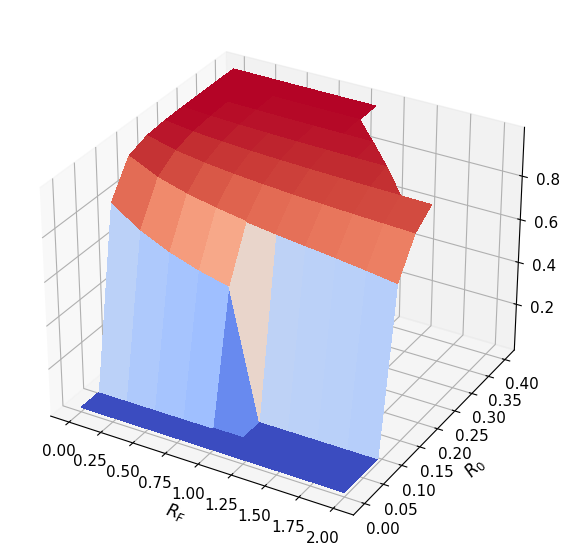

In [35]:
X, Y = np.meshgrid(R_F_, R_0_)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, z[:,:,1], cmap='coolwarm', linewidth=0, antialiased=False)
plt.xlabel('$R_F$', size=12)
plt.ylabel('$R_0$', size=12)

# References

- Perra N., Balcan D., Gonçalves B., Vespignani A. (2011) Towards a Characterization of Behavior-Disease Models. PLOS ONE 6(8): e23084. https://doi.org/10.1371/journal.pone.0023084

- http://www.socialcontactdata.org/socrates/



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51890446-0505-48b3-b3b7-32246abba1ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>